In [ ]:
1

1

人脸关键点检测是指给定人脸图像，定位出人脸面部的关键区域位置，如眉毛、眼睛、鼻子、嘴巴、脸部轮廓等。人脸关键点检测是人脸识别中的关键步骤。本文针对深度学习方法进行了人脸关键点检测的研究。近年来，基于深度学习的方法大幅提高了检测的速度和精度。本文介绍算法PFLD，利用神经网络实现人脸关键点检测。



# 目录
[1. 数据集简介](#1)<br>
[2. 模型介绍](#2)<br>
[3. 数据预处理](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1 划分数据集](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Pytorch读取数据](#3.2)<br>
[4. 模型构建](#4)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 关键点回归模型](#4.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 姿态估计模型](#4.2)<br>
[5. 模型训练](#5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 模型训练函数](#5.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 优化模型参数](#5.2)<br>
[6. 人脸关键点检测效果](#6)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 损失值变化](#5.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 人脸关键点检测](#5.2)<br>
[7. 总结](#7)<br>

<div id="1"></div>
# 1 数据集简介

案例采用WFLW数据集训练模型，数据集大小为724MB，是有较多人脸关键点标注的数据集。

解压数据集文件后，可以得到两个文件夹，其中`WFLW_images`文件夹下包含10000张图像，7500张图像为训练集，2500张图像为测试集。图像中涵盖了多种身份、场景下的人脸。如`1--Handshaking`文件夹下包含握手时的人脸姿态，`22--Picnic`文件夹中收集了野餐时的人像。

在`WFLW_annotations`文件夹下，包含着对图像中人脸关键点的标注，每张人脸标识出98个关键点。除关键点之外，还备注了人脸的属性信息，如遮挡，姿态，妆容，光照，模糊和表情等。

<div id="2"></div>
# 2 模型介绍

本案例采用PFLD模型作为人脸关键点检测器。PFLD的网络结构分为两个部分：关键点回归模型、姿态估计模型。

如下图所示，黄色框内为关键点回归模型的网络结构，用于检测人脸关键点的坐标。绿色框内为姿态估计模型，在训练时预测人脸姿态。



<div id="3"></div>
# 3 数据预处理

原始数据中图像和关键点标注是分开存放的，我们定义数据集接口，获取图像和其对应标注。

首先加载需要使用的库，便于后续调用函数。

In [ ]:
cp utils.py ../

In [ ]:
cp loss.py ../

In [ ]:
cp SetPreparation.py ../

In [ ]:
import numpy as np
import cv2
import shutil

import torch
import os
import torch.nn as nn

# import logging
# from pathlib import Path

from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn

from loss import PFLDLoss
from utils import AverageMeter, calculate_pitch_yaw_roll
from SetPreparation import rotate, ImageDate

from matplotlib import pyplot as plt
import random

<div id="3.1"></div>
## 3.1 划分数据集

原始数据集WFLW中共有10000张图像，为训练模型，我们需要将其划分为训练集和测试集。划分比例为训练集：测试集 = 3:1。

首先调用函数，解压zip文件夹，读取WFLW数据集。

In [ ]:
# 读取压缩为zip文件的数据集
!apt install unzip
!unzip WFLW.zip

同时读取人脸关键点数据，以及其对应的原图路径。

In [ ]:
def get_dataset_list(imgDir, outDir, landmarkDir, is_train):
    with open(landmarkDir,'r') as f:
        lines = f.readlines() # 读取人脸关键点坐标
        labels = []

        # 建立保存训练集和测试集的文件夹
        save_img = os.path.join(outDir, 'imgs')
        if not os.path.exists(save_img):
            os.mkdir(save_img)

        # 读取每张图像及其标注的人脸关键点
        for i, line in enumerate(lines):
            Img = ImageDate(line, imgDir)
            img_name = Img.path # 原图路径
            Img.load_data(is_train, 10, Mirror_file)
            _, filename = os.path.split(img_name) # 分割图像名和图像路径
            filename, _ = os.path.splitext(filename)
            label_txt = Img.save_data(save_img, str(i)+'_' + filename) # 图像名及其中人脸的标注点坐标
            labels.append(label_txt)
            
            # 显示划分测试集和训练集的进度
            if ((i + 1) % 1000) == 0:
                print('file: {}/{}'.format(i+1, len(lines)))

    # 保存图像路径和对应人脸关键点的数据
    with open(os.path.join(outDir, 'list.txt'),'w') as f:
        for label in labels:
            f.writelines(label)

原数据集中共10000张图像，定义函数将其分为包含7500张图像的训练集，和2500张图像的测试集，并将数据分别储存在`train_data`和`test_data`文件夹下。

In [ ]:
root_dir = "/content/"
imageDirs = 'WFLW/WFLW_images'
Mirror_file = 'WFLW/WFLW_annotations/Mirror98.txt'

landmarkDirs = ['WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt',
                'WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt']

outDirs = ['test_data', 'train_data']

In [ ]:
for landmarkDir, outDir in zip(landmarkDirs, outDirs):
    outDir = os.path.join(root_dir, outDir)
    print(outDir)
    
    if os.path.exists(outDir):  # 文件夹已存在
        shutil.rmtree(outDir) # 递归删除文件夹以及所有内容
    os.mkdir(outDir) # 创建文件夹
    
    # 构建测试集
    if 'list_98pt_rect_attr_test.txt' in landmarkDir:
        is_train = False
    
    # 构建训练集
    else:
        is_train = True
    
    # 划分出测试集和训练集
    imgs = get_dataset_list(imageDirs, outDir, landmarkDir, is_train)

print('end')

/content/test_data
file: 1000/2500
file: 2000/2500
/content/train_data
file: 1000/7500
file: 2000/7500
file: 3000/7500
file: 4000/7500
file: 5000/7500
file: 6000/7500
file: 7000/7500
end


<div id="3.2"></div>
## 3.2 Pytorch读取数据

接下来定义`WLFWDatasets`类，加载训练集和测试集的数据。

In [ ]:
class WLFWDatasets(data.Dataset):
    def __init__(self, file_list, transforms=None):
        self.line = None
        self.path = None
        self.landmarks = None
        self.attribute = None
        self.filenames = None
        self.euler_angle = None
        self.transforms = transforms

        # 读取txt文件
        with open(file_list, 'r') as f:
            self.lines = f.readlines()

    def __getitem__(self, index):
        # 储存图像路径
        self.line = self.lines[index].strip().split()
        self.img = cv2.imread(self.line[0])
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        self.landmark = np.asarray(self.line[1:197], dtype=np.float32) # 98个人脸关键点
        self.attribute = np.asarray(self.line[197:203], dtype=np.int32) # 6个人脸属性
        self.euler_angle = np.asarray(self.line[203:206], dtype=np.float32) # 3个欧拉角
        if self.transforms:
            self.img = self.transforms(self.img)
        return (self.img, self.landmark, self.attribute, self.euler_angle)

    def __len__(self):
        return len(self.lines)

定义了函数`WLFWDatasets`后，现在调用函数加载数据，并且调用`DataLoader`函数读取数据，并将其分为多个批次（batch），在模型训练时可以分批次进行训练。

In [ ]:
# 数据路径
dataroot='/content/train_data/list.txt'
val_dataroot='/content/test_data/list.txt'

# 每个batch的大小
train_batchsize=256
val_batchsize=256

transform = transforms.Compose([transforms.ToTensor()])

# 读取训练集
wlfwdataset = WLFWDatasets(dataroot, transform)
dataloader = DataLoader(wlfwdataset, batch_size=train_batchsize, shuffle=True, num_workers=0, drop_last=False)

# 读取测试集
wlfw_val_dataset = WLFWDatasets(val_dataroot, transform)
wlfw_val_dataloader = DataLoader(wlfw_val_dataset, batch_size=val_batchsize, shuffle=False, num_workers=0)

<div id="4"></div>
# 4 模型构建

模型包含两个部分，分别为关键点回归模型和姿态估计模型。我们首先介绍关键点模型的构造方法。这一回归模型基于MobileNet V2，不同于MobileNet V1，它使用了“漏斗型”的残差模块。

首先搭建一个神经网络模块，便于后续调用，由卷积层、批量归一化层（BN层）构成。


In [ ]:
def conv_bn(inp, oup, kernel, stride, padding=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(oup), nn.ReLU(inplace=True))

接下来介绍“漏斗型”的残差模块，它包含3个卷积层。第一个卷积层采用$1 \times 1$的卷积核，实现升维；第二个卷积层采用$3 \times 3$的卷积核，进行分组卷积；第三个卷积层同样采用$1 \times 1$的卷积核，实现降维。

这一构造中，中间层的维度较高，所以被称为“漏斗型”的残差模块。通过设置变量`use_res_connect`的值，可以决定是否使用跳层连接。

In [ ]:
class InvertedResidual(nn.Module):
    # 神经网络
    def __init__(self, inp, oup, stride, use_res_connect, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2] # 步长为1或2

        self.use_res_connect = use_res_connect # 决定是否使用跳层连接

        self.conv = nn.Sequential(
            # 1*1卷积层，输入通道数为inp，转换为inp * expand_ratio
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU(inplace=True),

            # 3*3 分组卷积层
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio,3, stride,
                      1, groups=inp * expand_ratio, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU(inplace=True),
            
            # 1*1卷积层，输入通道数为inp * expand_ratio， 转换为oup
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    # 前向传播
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

构造关键点模型`PFLDInference`，需要调用“漏斗型”的残差模块`InvertedResidual`。模型的构造为：首先通过两层卷积层，提取特征；再使用堆叠的“漏斗型”残差模块；最后融合3个特征尺度。

其中第1个特征尺度为$14 \times 14$，经过全局平均池化后，维度为16；第2个特征尺度为$7 \times 7$，经全局平均池化后维度为32；第3个特征尺度为$1 \times 1$，维度为128。融合三个特征维度的信息后，总特征向量维度为176。输入全连接层，得到196维的人脸关键点坐标，储存在变量`landmarks`中。另一个输出数据`out1`为接下来介绍的姿态估计网络的输入数据。

In [ ]:
class PFLDInference(nn.Module):
    def __init__(self):
        super(PFLDInference, self).__init__()

        # 第一层卷积层 输入图像数据，输出通道为64，卷积核大小 = 3，步长 = 2
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 第二层卷积层 输入通道为64，输出通道为64，卷积核大小 = 3，步长 = 1
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 漏斗型残差模块
        self.conv3_1 = InvertedResidual(64, 64, 2, False, 2)
        self.block3_2 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_3 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_4 = InvertedResidual(64, 64, 1, True, 2)
        self.block3_5 = InvertedResidual(64, 64, 1, True, 2)
        self.conv4_1 = InvertedResidual(64, 128, 2, False, 2)
        self.conv5_1 = InvertedResidual(128, 128, 1, False, 4)
        self.block5_2 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_3 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_4 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_5 = InvertedResidual(128, 128, 1, True, 4)
        self.block5_6 = InvertedResidual(128, 128, 1, True, 4)
        self.conv6_1 = InvertedResidual(128, 16, 1, False, 2)  # [16, 14, 14]

        # 卷积层，输入通道为16，输出通道为32，卷积核大小 = 3，步长 = 2
        self.conv7 = conv_bn(16, 32, 3, 2)  # [32, 7, 7]
        
        # 卷积层，输入通道为32，输出通道为128，卷积核大小 = 3
        self.conv8 = nn.Conv2d(32, 128, 7, 1, 0)  # [128, 1, 1]
        self.bn8 = nn.BatchNorm2d(128)

        # 全局平均池化层
        self.avg_pool1 = nn.AvgPool2d(14)
        self.avg_pool2 = nn.AvgPool2d(7)

        # 全连接层
        self.fc = nn.Linear(176, 196)

    # 前向传播
    def forward(self, x):  # x: 3, 112, 112
        x = self.relu(self.bn1(self.conv1(x)))  # [64, 56, 56]
        x = self.relu(self.bn2(self.conv2(x)))  # [64, 56, 56]
        x = self.conv3_1(x)
        x = self.block3_2(x)
        x = self.block3_3(x)
        x = self.block3_4(x)
        out1 = self.block3_5(x)

        x = self.conv4_1(out1)
        x = self.conv5_1(x)
        x = self.block5_2(x)
        x = self.block5_3(x)
        x = self.block5_4(x)
        x = self.block5_5(x)
        x = self.block5_6(x)
        x = self.conv6_1(x)
        
        x1 = self.avg_pool1(x)
        x1 = x1.view(x1.size(0), -1) # 第1个特征，维度为16
        x = self.conv7(x)
        x2 = self.avg_pool2(x) # 第2个特征，维度为32
        x2 = x2.view(x2.size(0), -1)
        x3 = self.relu(self.conv8(x))
        x3 = x3.view(x3.size(0), -1) # 第3个特征，维度为128

        # 多尺度的特征相融合
        multi_scale = torch.cat([x1, x2, x3], 1)
        
        # 输出人脸关键点
        landmarks = self.fc(multi_scale)

        return out1, landmarks

姿态估计网络在训练时预测人脸姿态，给网络加这个辅助任务可以提高定位精度。其网络构造为4个卷积层、1个最大池化层和2个全连接层。

姿态估计网络的第1个卷积层的输入为关键点模型`PFLDInference`的中间特征层的输出，即两个网络实现了底层特征共享。

In [ ]:
class AuxiliaryNet(nn.Module):
    def __init__(self):
        super(AuxiliaryNet, self).__init__()
        
        # 卷积层
        self.conv1 = conv_bn(64, 128, 3, 2)
        self.conv2 = conv_bn(128, 128, 3, 1)
        self.conv3 = conv_bn(128, 32, 3, 2)
        self.conv4 = conv_bn(32, 128, 7, 1)

        # 最大池化层，卷积核3*3
        self.max_pool1 = nn.MaxPool2d(3)

        # 全连接层
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

<div id="5"></div>
# 5 模型训练

<div id="5.1"></div>
## 5.1 模型训练函数

在进行模型训练前，首先要定义模型训练的函数。下列函数中，`train`函数定义了优化模型参数的过程。通过读入数据、预测人脸关键点、计算损失值、反向传播等过程，不断优化模型参数，提高预测人脸关键点的精度。

In [ ]:
def train(train_loader, pfld_backbone, auxiliarynet, criterion, optimizer, epoch):

    # 初始化损失值
    losses = AverageMeter()
    weighted_loss, loss = None, None 

    # 优化模型参数
    for img, landmark_gt, attribute_gt, euler_angle_gt in train_loader:
        # 读取数据，预测人脸关键点
        img = img.to(device)
        attribute_gt = attribute_gt.to(device)
        landmark_gt = landmark_gt.to(device)
        euler_angle_gt = euler_angle_gt.to(device)
        pfld_backbone = pfld_backbone.to(device)
        auxiliarynet = auxiliarynet.to(device)
        features, landmarks = pfld_backbone(img)
        angle = auxiliarynet(features)

        # 计算损失值
        weighted_loss, loss = criterion(attribute_gt, landmark_gt, euler_angle_gt, angle, landmarks, train_batchsize)
        
        # 反向传播、优化模型参数
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()
        losses.update(loss.item())
        
    return weighted_loss, loss

此外，还需定义`validate`函数，可以在训练模型时，判断模型在验证集上的检测效果，并不改变模型参数。

In [ ]:
def validate(wlfw_val_dataloader, pfld_backbone, auxiliarynet, criterion):
    pfld_backbone.eval()
    auxiliarynet.eval()
    losses = []
    with torch.no_grad():
        for img, landmark_gt, attribute_gt, euler_angle_gt in wlfw_val_dataloader:
            img = img.to(device)
            attribute_gt = attribute_gt.to(device)
            landmark_gt = landmark_gt.to(device)
            euler_angle_gt = euler_angle_gt.to(device)
            pfld_backbone = pfld_backbone.to(device)
            auxiliarynet = auxiliarynet.to(device)
            _, landmark = pfld_backbone(img)
            loss = torch.mean(torch.sum((landmark_gt - landmark)**2, axis=1))
            losses.append(loss.cpu().numpy())
    return np.mean(losses)

`save_checkpoint`函数能够保存训练好的模型参数，避免重复训练模型。

In [ ]:
# 保存模型参数
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    # logging.info('Save checkpoint to {0:}'.format(filename))

<div id="5.2"></div>
## 5.2 优化模型参数

定义好训练模型所需要的函数后，现在可以进行模型的训练，以得到最优的模型参数。

首先给定变量的初始值，如指定运行设备、选择网络主体等。

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 运行设备

# 加载模型
pfld_backbone = PFLDInference().to(device) 
auxiliarynet = AuxiliaryNet().to(device)
criterion = PFLDLoss() # 损失函数
optimizer = torch.optim.Adam([{'params': pfld_backbone.parameters()}, {'params': auxiliarynet.parameters()}],
                             lr=0.0001,weight_decay=1e-6) # 优化器算法
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=40, verbose=True) # 调整学习率

下面进行模型训练，本案例进行50个Epoch的训练（Epoch：将所有训练样本训练一次），并储存每个Epoch的训练结果，以及损失值。

In [ ]:
val_loss_list = []
train_loss_list = []

start_epoch=1
end_epoch=50

for epoch in range(start_epoch, end_epoch + 1):
    print("===> Epoch: ",epoch)
    weighted_train_loss, train_loss = train(dataloader, pfld_backbone, auxiliarynet, criterion, optimizer, epoch)
    filename = os.path.join(str("/content"), "checkpoint_epoch_" + str(epoch) + '.pth.tar')
    save_checkpoint(
        { 'epoch': epoch,
         'pfld_backbone': pfld_backbone.state_dict(),
         'auxiliarynet': auxiliarynet.state_dict()
        }, filename)

    val_loss = validate(wlfw_val_dataloader, pfld_backbone, auxiliarynet, criterion)

    scheduler.step(val_loss)
    print('Train Loss: {:.4f} ; Val Loss: {:.4f} '.format(train_loss, val_loss))
    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

===> Epoch:  1
Train Loss: 2.5348 ; Val Loss: 1.8770 
===> Epoch:  2
Train Loss: 2.1838 ; Val Loss: 1.6415 
===> Epoch:  3
Train Loss: 1.6961 ; Val Loss: 1.1987 
===> Epoch:  4
Train Loss: 1.2870 ; Val Loss: 0.9331 
===> Epoch:  5
Train Loss: 0.9243 ; Val Loss: 0.7882 
===> Epoch:  6
Train Loss: 0.8429 ; Val Loss: 0.7336 
===> Epoch:  7
Train Loss: 0.9066 ; Val Loss: 0.6601 
===> Epoch:  8
Train Loss: 0.8607 ; Val Loss: 0.6118 
===> Epoch:  9
Train Loss: 0.6693 ; Val Loss: 0.5603 
===> Epoch:  10
Train Loss: 0.7791 ; Val Loss: 0.5367 
===> Epoch:  11
Train Loss: 0.5867 ; Val Loss: 0.5045 
===> Epoch:  12
Train Loss: 0.5293 ; Val Loss: 0.4847 
===> Epoch:  13
Train Loss: 0.5174 ; Val Loss: 0.4630 
===> Epoch:  14
Train Loss: 0.5923 ; Val Loss: 0.4622 
===> Epoch:  15
Train Loss: 0.4638 ; Val Loss: 0.4307 
===> Epoch:  16
Train Loss: 0.4690 ; Val Loss: 0.4148 
===> Epoch:  17
Train Loss: 0.3621 ; Val Loss: 0.3942 
===> Epoch:  18
Train Loss: 0.4472 ; Val Loss: 0.3909 
===> Epoch:  19
Tra

<div id="6"></div>
# 6 人脸关键点检测效果

<div id="6.1"></div>
## 6.1 损失值变化

首先展示训练过程中，模型在训练集和验证集上的损失值。由下图可以看到，随着训练次数的增加（即Epoch值的增大），训练集和验证集上的损失值不断降低，证明模型识别人脸关键点的精度不断提高。

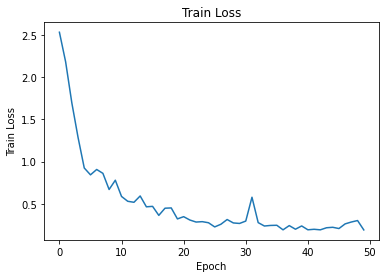

In [ ]:
plt.plot(train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss")
plt.show()

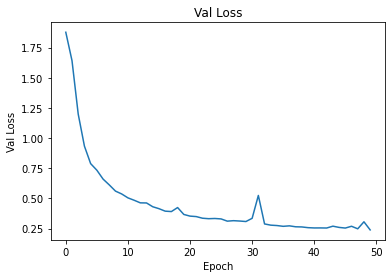

In [ ]:
plt.plot(val_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("Val Loss")
plt.show()

<div id="6.2"></div>
## 6.2 人脸关键点检测

读取训练50个Epoch后，得到的模型参数，在测试集上进行人脸关键点检测，直观展示模型的检测效果。

In [ ]:
# 读取压缩为zip文件的数据集
!apt install unzip
!unzip checkpoint.zip

定义展示识别结果的函数，通过`cv2`模块，将检测出的关键点添加到原始人脸图像中，并展示结果。

In [ ]:
def predict(wlfw_val_dataloader, plfd_backbone, auxiliarynet):
    # 读取模型，不修改参数
    plfd_backbone.eval()
    auxiliarynet.eval()

    with torch.no_grad():
        for img, landmark_gt, attribute_gt, euler_angle_gt in wlfw_val_dataloader:
            # 加载图像
            img = img.cuda(non_blocking=True)
            
            # 检测人脸关键点
            _, landmarks = plfd_backbone(img)
            landmarks = landmarks.cpu().numpy()
            landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)

            # 在图像上添加人脸关键点
            show_img = np.array(np.transpose(img[0].cpu().numpy(), (1, 2, 0)))
            show_img = (show_img * 256).astype(np.uint8)
            np.clip(show_img, 0, 255)
            pre_landmark = landmarks[0] * [112, 112]
            cv2.imwrite("xxx.jpg", show_img)
            img_clone = cv2.imread("xxx.jpg")
            for (x, y) in pre_landmark.astype(np.int32):
                cv2.circle(img_clone, (x, y), 1, (0,255,0),0)
            
            # 展示图像
            plt.imshow(img_clone)
            plt.show()
            break

给定变量值，并读取训练好的模型。

In [ ]:
model_path="/content/checkpoint/checkpoint_epoch_49.pth.tar"
test_dataset="/content/test_data/list.txt"

In [ ]:
# 读取关键点回归模型
checkpoint = torch.load(model_path, map_location=device)
pfld_backbone = PFLDInference().to(device)
pfld_backbone.load_state_dict(checkpoint['pfld_backbone'])

<All keys matched successfully>

In [ ]:
# 读取姿态估计模型
auxiliarynet = AuxiliaryNet().cuda()
auxiliarynet.load_state_dict(checkpoint['auxiliarynet'])

<All keys matched successfully>

设定随机种子，固定选取的人脸图像，以分析人脸关键点检测结果。

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

如下图所示，模型能够较为精准地检测人脸上98个关键点，且边缘部分即使受到头发的遮挡，模型也能够准确地标注出关键点。

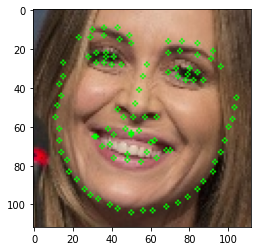

In [ ]:
setup_seed(25)
wlfw_val_dataloader = DataLoader(wlfw_val_dataset, batch_size=8, shuffle=True, num_workers=0)
predict(wlfw_val_dataloader, pfld_backbone, auxiliarynet)

<div id="7"></div>
# 7 总结

本案例介绍了人脸关键点检测的步骤，并展示了检测效果。首先读取WLFW数据集，并划分为训练集和测试集。再构建关键点回归模型和姿态估计模型，在训练集上进行50个Epoch的模型训练。最后代入测试集图像，展示检测效果。可以看到，经过多个Epoch训练后，模型的检测效果较好，能够准确地检测出人脸关键点的位置。